Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve,precision_recall_curve,f1_score,auc
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split
from time import time
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import tensorflow 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import re
import gensim

Import Dataset

In [2]:
formspring='https://raw.githubusercontent.com/eimearfoley/CyberBullyingDetection/master/data/formspring.csv'

In [3]:
df=pd.read_csv(formspring)

Analyze Dataset

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12901 entries, 0 to 12900
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     12896 non-null  object
 1   post       12852 non-null  object
 2   ques       12852 non-null  object
 3   ans        12820 non-null  object
 4   asker      12801 non-null  object
 5   ans1       12759 non-null  object
 6   severity1  12788 non-null  object
 7   bully1     1909 non-null   object
 8   ans2       12701 non-null  object
 9   severity2  12739 non-null  object
 10  bully2     1786 non-null   object
 11  ans3       12655 non-null  object
 12  severity3  12698 non-null  object
 13  bully3     1780 non-null   object
dtypes: object(14)
memory usage: 1.4+ MB


,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
0,aguitarplayer94,Q: what&#039;s your favorite song? :D<br>A: I ...,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,None,No,0,NaN,No,0,NaN,No,0,NaN
1,aprilpooh15,Q: <3<br>A: </3 ? haha jk! <33,<3,</3 ? haha jk! <33,None,No,0,NaN,No,0,NaN,No,0,NaN
2,aprilpooh15,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,None,No,0,NaN,No,0,NaN,No,0,NaN
3,aprilpooh15,Q: (:<br>A: ;(,(:,;(,None,No,0,NaN,No,0,NaN,No,0,NaN
4,aprilpooh15,Q: ******************MEOWWW*******************...,******************MEOWWW*************************,*RAWR*?,None,No,0,NaN,No,0,NaN,No,0,NaN


In [5]:
df['post'][:10]

0    Q: what&#039;s your favorite song? :D<br>A: I ...
1                       Q: <3<br>A: </3 ? haha jk! <33
2    Q: &quot;hey angel  you duh sexy&quot;<br>A: R...
3                                       Q: (:<br>A: ;(
4    Q: ******************MEOWWW*******************...
5    Q: any makeup tips? i suck at doing my makeup ...
6    Q: Apriiiiiiiiiiiill!!! I miss uuuu! It&#039;s...
7    Q: Are you a morning or night person?<br>A: Ni...
8    Q: are you a trusting person?<br>A: alreadi an...
9    Q: are you a trusting person?<br>A: Yes veryy ...
Name: post, dtype: object

In [6]:
df['ques'][:10]

0               what&#039;s your favorite song? :D<br>
1                                                   <3
2                  &quot;hey angel  you duh sexy&quot;
3                                                   (:
4    ******************MEOWWW*************************
5       any makeup tips? i suck at doing my makeup lol
6    Apriiiiiiiiiiiill!!! I miss uuuu! It&#039;s Em...
7                   Are you a morning or night person?
8                           are you a trusting person?
9                           are you a trusting person?
Name: ques, dtype: object

In [7]:
df['ans'][:10]

0             I like too many songs to have a favorite
1                                   </3 ? haha jk! <33
2                             Really?!?! Thanks?! haha
3                                                   ;(
4                                              *RAWR*?
5     Sure! Like tell me wht u wnna know?! Like wht...
6     EMMA hahahahah :D I MISSSSSeddd YUHHHHh 22222...
7                                      Night 4shuree!!
8                                       alreadi answrd
9         Yes veryy trustin person!!! May i help yuh:!
Name: ans, dtype: object

In [8]:
df['bully1'][100:110]

100    NaN
101    NaN
102    NaN
103    NaN
104    NaN
105    NaN
106    NaN
107    NaN
108    NaN
109    NaN
Name: bully1, dtype: object

In [9]:
df['bully1'].value_counts()

None                               593
Na                                  89
N/A.                                74
N/a                                 47
no                                  47
                                  ... 
sexual                               1
listen asshole                       1
"""sexy, dumbasssssss, bitch"""      1
Prank call this person               1
BULLSHIT                             1
Name: bully1, Length: 1012, dtype: int64

In [10]:
print(df['ans1'].value_counts())
print(df['ans2'].value_counts())
print(df['ans3'].value_counts())

No     11693
Yes     1038
0         12
5          5
3          5
1          2
4          1
7          1
2          1
6          1
Name: ans1, dtype: int64
No     11696
Yes     1005
Name: ans2, dtype: int64
No     11711
Yes      944
Name: ans3, dtype: int64


In [11]:
df = df[df['post'].notna()]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12852 entries, 0 to 12900
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userid     12852 non-null  object
 1   post       12852 non-null  object
 2   ques       12850 non-null  object
 3   ans        12819 non-null  object
 4   asker      12801 non-null  object
 5   ans1       12759 non-null  object
 6   severity1  12788 non-null  object
 7   bully1     1909 non-null   object
 8   ans2       12701 non-null  object
 9   severity2  12739 non-null  object
 10  bully2     1786 non-null   object
 11  ans3       12655 non-null  object
 12  severity3  12698 non-null  object
 13  bully3     1780 non-null   object
dtypes: object(14)
memory usage: 1.5+ MB


In [13]:
ans=np.array(df['ans'])
ques=np.array(df['ques'])
posts=[]
for i in range (0,len(ans)):
  posts.append(str(ques[i])+str(ans[i]))

In [14]:
print(ques[0])
print(ans[0])
print(posts[0])

what&#039;s your favorite song? :D<br>
 I like too many songs to have a favorite
what&#039;s your favorite song? :D<br> I like too many songs to have a favorite


In [15]:
y1=np.array(df['ans1'])
y2=np.array(df['ans2'])
y3=np.array(df['ans3'])

In [16]:
X=[]
y=[]
for i in range (len(posts)):
  X.append(posts[i])
  if y1[i]=='Yes' :
    y.append(1)
  else:
    y.append(0)

Data Preprocessing

In [17]:
X=np.array(X)
X=np.reshape(X,(-1,1))
y=np.array(y)


In [18]:
X.shape,y.shape

((12852, 1), (12852,))

In [19]:
print(Counter(y))

Counter({0: 11814, 1: 1038})


In [20]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler( sampling_strategy=0.3)
X,y=oversample.fit_sample(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [21]:
X.shape,y.shape

((15358, 1), (15358,))

In [22]:
print(Counter(y))

Counter({0: 11814, 1: 3544})


In [23]:
X[:6],y[:6]

(array([['what&#039;s your favorite song? :D<br> I like too many songs to have a favorite'],
        ['<3 </3 ? haha jk! <33'],
        ['&quot;hey angel  you duh sexy&quot; Really?!?! Thanks?! haha'],
        ['(: ;('],
        ['******************MEOWWW************************* *RAWR*?'],
        ['any makeup tips? i suck at doing my makeup lol Sure! Like tell me wht u wnna know?! Like wht do you use?!']],
       dtype='<U5541'), array([0, 0, 0, 0, 0, 0]))

In [24]:
type(X)

numpy.ndarray

In [25]:
X=[str(x) for x in X]

In [26]:
type(X)

list

Create Word Embeddings

In [28]:
stopwords=stopwords.words('english')

In [29]:
contractions =dict({ 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": " he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that has",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who has",
"who've": "who have",
"why's": "why has",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
"ain’t": "am not",
"aren’t": "are not",
"can’t": "cannot",
"can’t’ve": "cannot have",
"’cause": "because",
"could’ve": "could have",
"couldn’t": "could not",
"couldn’t’ve": "could not have",
"didn’t": "did not",
"doesn’t": "does not",
"don’t": "do not",
"hadn’t": "had not",
"hadn’t’ve": "had not have",
"hasn’t": "has not",
"haven’t": "have not",
"he’d": " he would",
"he’d’ve": "he would have",
"he’ll": "he will",
"he’ll’ve": "he will have",
"he’s": "he is",
"how’d": "how did",
"how’d’y": "how do you",
"how’ll": "how will",
"how’s": "how is",
"i’d": "i would",
"i’d’ve": "i would have",
"i’ll": "i will",
"i’ll’ve": "i will have",
"i’m": "i am",
"i’ve": "i have",
"isn’t": "is not",
"it’d": "it would",
"it’d’ve": "it would have",
"it’ll": "it will",
"it’ll’ve": "it will have",
"it’s": "it is",
"let’s": "let us",
"ma’am": "madam",
"mayn’t": "may not",
"might’ve": "might have",
"mightn’t": "might not",
"mightn’t’ve": "might not have",
"must’ve": "must have",
"mustn’t": "must not",
"mustn’t’ve": "must not have",
"needn’t": "need not",
"needn’t’ve": "need not have",
"o’clock": "of the clock",
"oughtn’t": "ought not",
"oughtn’t’ve": "ought not have",
"shan’t": "shall not",
"sha’n’t": "shall not",
"shan’t’ve": "shall not have",
"she’d": "she would",
"she’d’ve": "she would have",
"she’ll": "she will",
"she’ll’ve": "she will have",
"she’s": "she is",
"should’ve": "should have",
"shouldn’t": "should not",
"shouldn’t’ve": "should not have",
"so’ve": "so have",
"so’s": "so is",
"that’d": "that would",
"that’d’ve": "that would have",
"that’s": "that has",
"there’d": "there would",
"there’d’ve": "there would have",
"there’s": "there is",
"they’d": "they had",
"they’d’ve": "they would have",
"they’ll": "they will",
"they’ll’ve": "they will have",
"they’re": "they are",
"they’ve": "they have",
"to’ve": "to have",
"wasn’t": "was not",
"we’d": "we would",
"we’d’ve": "we would have",
"we’ll": "we will",
"we’ll’ve": "we will have",
"we’re": "we are",
"we’ve": "we have",
"weren’t": "were not",
"what’ll": "what will",
"what’ll’ve": "what will have",
"what’re": "what are",
"what’s": "what is",
"what’ve": "what have",
"when’s": "when is",
"when’ve": "when have",
"where’d": "where did",
"where’s": "where is",
"where’ve": "where have",
"who’ll": "who will",
"who’ll’ve": "who will have",
"who’s": "who has",
"who’ve": "who have",
"why’s": "why has",
"why’ve": "why have",
"will’ve": "will have",
"won’t": "will not",
"won’t’ve": "will not have",
"would’ve": "would have",
"wouldn’t": "would not",
"wouldn’t’ve": "would not have",
"y’all": "you all",
"y’all’d": "you all would",
"y’all’d’ve": "you all would have",
"y’all’re": "you all are",
"y’all’ve": "you all have",
"you’d": "you would",
"you’d’ve": "you would have",
"you’ll": "you will",
"you’ll’ve": "you will have",
"you’re": "you are",
"you’ve": "you have"
})

In [30]:
contractions["it’s"]

'it is'

In [31]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [32]:
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 8273, 1: 2477})
Counter({0: 3541, 1: 1067})


In [33]:
def cleanText(X):
  corpus=[]
  for para in X:
      sentences=nltk.sent_tokenize(str(para))
      temp=[]
      for sentence in sentences:
          sentence=sentence.lower()
          cleanr = re.compile('<.*?>')
          sentence = re.sub(cleanr, '', sentence)
          sentence=re.sub(r'[\!"#$%&\*+,./;<=>?@_`|~=]','',sentence)
          sentence=re.sub(r'[0-9]+', '',sentence)
          words=sentence.split()
          words_list=[]
          for word in words:
            if word in contractions:
              words_list.append(contractions[word])
            elif word not in stopwords:
              words_list.append(WordNetLemmatizer().lemmatize(word) )
          sent=' '.join(words_list)
          sent=re.sub(pattern=r'\'',repl='',string=sent)
          temp.append(sent)
      corpus.append('. '.join(temp))
  return corpus

In [34]:
corpus=cleanText(X_train)
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)


In [35]:
print(len(corpus))
print(len(lst_corpus))

10750
10750


In [36]:
corpus[:6]

['[awhh shit dx man. (: taelin walker webb ]',
 '[if could watch one tv show would. office ]',
 '[why cant fuck get girl. :] god really hope ashley haha. (:r ashley: talking time hahahaha (r someone else: because i am straight hun. sorryyy (]',
 '[its prolly think wanted know thought :) welll]',
 '[holar :) wasup]',
 '[lol :] anonymous]']

In [37]:
lst_corpus[:6]

[['[awhh', 'shit', 'dx', 'man.', '(:', 'taelin', 'walker', 'webb', ']'],
 ['[if', 'could', 'watch', 'one', 'tv', 'show', 'would.', 'office', ']'],
 ['[why',
  'cant',
  'fuck',
  'get',
  'girl.',
  ':]',
  'god',
  'really',
  'hope',
  'ashley',
  'haha.',
  '(:r',
  'ashley:',
  'talking',
  'time',
  'hahahaha',
  '(r',
  'someone',
  'else:',
  'because',
  'i',
  'am',
  'straight',
  'hun.',
  'sorryyy',
  '(]'],
 ['[its', 'prolly', 'think', 'wanted', 'know', 'thought', ':)', 'welll]'],
 ['[holar', ':)', 'wasup]'],
 ['[lol', ':]', 'anonymous]']]

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

In [39]:
X_train= tokenizer.texts_to_sequences(lst_corpus)

In [40]:
arr=[]
arr=[len(x) for x in corpus if len(x)<500]

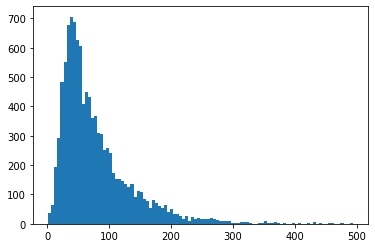

In [41]:
plt.hist(arr,bins=100)
plt.show()

In [42]:
max_length=100
X_train=pad_sequences(X_train,maxlen=max_length,padding='post')

In [43]:
X_train.shape,y_train.shape

((10750, 100), (10750,))

In [44]:
corpus=cleanText(X_test)

lst_corpus_test = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus_test.append(lst_grams)

X_test = tokenizer.texts_to_sequences(lst_corpus_test)

X_test=pad_sequences(X_test,maxlen=max_length,padding='post')

In [45]:
print(len(corpus))
print(len(lst_corpus))

4608
10750


In [46]:
X_test.shape,y_test.shape

((4608, 100), (4608,))

In [47]:
filter_sizes = [2,3,4]
num_filters = 100
drop = 0.5

In [48]:
def pipeline(X_train, y_train, X_test, y_test,n,flag): 
   
    results = {}
    final_results = []
    for num in n:  

      wv_model = gensim.models.word2vec.Word2Vec(lst_corpus,size=num,window=4,min_count=1,sg=flag,iter=30)

      embedding_dim = num
      embedding_matrix = np.zeros((len(dic_vocabulary)+1, embedding_dim))
      for word, i in tokenizer.word_index.items():
        try:
            embedding_matrix[i]=wv_model[word]
        except:
            pass

      tensorflow.keras.backend.clear_session()
      
      #CNN
      embedding_layer=layers.Embedding(input_dim=embedding_matrix.shape[0],output_dim=embedding_matrix.shape[1],weights=[embedding_matrix],input_length=max_length,trainable=False)

      inputs = layers.Input(shape=(max_length,), dtype='int32')
      embedding = embedding_layer(inputs)

      reshape = layers.Reshape((max_length,embedding_dim,1))(embedding)

      conv_0 = layers.Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
      conv_1 = layers.Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
      conv_2 = layers.Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

      maxpool_0 = layers.MaxPool2D(pool_size=(max_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
      maxpool_1 = layers.MaxPool2D(pool_size=(max_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
      maxpool_2 = layers.MaxPool2D(pool_size=(max_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

      concatenated_tensor = layers.Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
      flatten = layers.Flatten()(concatenated_tensor)
      dropout = layers.Dropout(drop)(flatten)
      output = layers.Dense(units=1, activation='sigmoid')(dropout)

      model = Model(inputs=inputs, outputs=output)

      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

      start=time()
      model.fit(X_train,y_train,epochs=10)
      end=time()
      
        
      results['Algorithm'] = 'embedding'+str(num)

      start = time() 
      predictions_test = model.predict(X_test)
      predictions_test=[np.round(i) for i in predictions_test]
      end = time() 
    
      results['Prediction Time'] = end - start

      results['Accuracy'] = accuracy_score(y_test, predictions_test)

      results['F1 Score'] = f1_score(y_test, predictions_test)
      
      results['AUC Score'] = roc_auc_score(y_test, predictions_test)

      results['Precision'] = precision_score(y_test, predictions_test)

      results['Recall'] = recall_score(y_test, predictions_test)

      
      final_results.append(results.copy())
    return final_results

In [49]:
n=[50,100,150,200,250,300,350,400]

CBOW

In [50]:
re = pipeline(X_train, y_train, X_test, y_test,n,0)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC Score', 'Prediction Time'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 5s 6ms/step - loss: 0.4909 - accuracy: 0.8025
Epoch 2/10
336/336 [==============================] - 2s 5ms/step - loss: 0.3706 - accuracy: 0.8464
Epoch 3/10
336/336 [==============================] - 2s 5ms/step - loss: 0.3251 - accuracy: 0.8658
Epoch 4/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2939 - accuracy: 0.8783
Epoch 5/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2739 - accuracy: 0.8890
Epoch 6/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2547 - accuracy: 0.8993
Epoch 7/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2399 - accuracy: 0.9059
Epoch 8/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2264 - accuracy: 0.9108
Epoch 9/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2145 - accuracy: 0.9140
Epoch 10/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2036 - accuracy: 0.9214

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 8ms/step - loss: 0.4861 - accuracy: 0.8017
Epoch 2/10
336/336 [==============================] - 2s 7ms/step - loss: 0.3585 - accuracy: 0.8530
Epoch 3/10
336/336 [==============================] - 2s 7ms/step - loss: 0.3219 - accuracy: 0.8630
Epoch 4/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2899 - accuracy: 0.8817
Epoch 5/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2602 - accuracy: 0.8975
Epoch 6/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2535 - accuracy: 0.8997
Epoch 7/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2380 - accuracy: 0.9064
Epoch 8/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2216 - accuracy: 0.9153
Epoch 9/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2045 - accuracy: 0.9198
Epoch 10/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2000 - accuracy: 0.9208

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 5ms/step - loss: 0.4859 - accuracy: 0.8080
Epoch 2/10
336/336 [==============================] - 1s 4ms/step - loss: 0.3621 - accuracy: 0.8484
Epoch 3/10
336/336 [==============================] - 1s 4ms/step - loss: 0.3196 - accuracy: 0.8689
Epoch 4/10
336/336 [==============================] - 1s 4ms/step - loss: 0.2960 - accuracy: 0.8801
Epoch 5/10
336/336 [==============================] - 1s 4ms/step - loss: 0.2688 - accuracy: 0.8905
Epoch 6/10
336/336 [==============================] - 1s 4ms/step - loss: 0.2551 - accuracy: 0.8981
Epoch 7/10
336/336 [==============================] - 1s 4ms/step - loss: 0.2401 - accuracy: 0.9047
Epoch 8/10
336/336 [==============================] - 1s 4ms/step - loss: 0.2290 - accuracy: 0.9098
Epoch 9/10
336/336 [==============================] - 1s 4ms/step - loss: 0.2130 - accuracy: 0.9186
Epoch 10/10
336/336 [==============================] - 1s 4ms/step - loss: 0.2125 - accuracy: 0.9196

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 6ms/step - loss: 0.4886 - accuracy: 0.8069
Epoch 2/10
336/336 [==============================] - 2s 5ms/step - loss: 0.3648 - accuracy: 0.8500
Epoch 3/10
336/336 [==============================] - 2s 5ms/step - loss: 0.3269 - accuracy: 0.8655
Epoch 4/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2978 - accuracy: 0.8776
Epoch 5/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2799 - accuracy: 0.8887
Epoch 6/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2566 - accuracy: 0.8961
Epoch 7/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2481 - accuracy: 0.9026
Epoch 8/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2340 - accuracy: 0.9103
Epoch 9/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2212 - accuracy: 0.9134
Epoch 10/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2086 - accuracy: 0.9175

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 7ms/step - loss: 0.4714 - accuracy: 0.8138
Epoch 2/10
336/336 [==============================] - 2s 5ms/step - loss: 0.3680 - accuracy: 0.8483
Epoch 3/10
336/336 [==============================] - 2s 5ms/step - loss: 0.3271 - accuracy: 0.8660
Epoch 4/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2996 - accuracy: 0.8788
Epoch 5/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2760 - accuracy: 0.8901
Epoch 6/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2638 - accuracy: 0.8949
Epoch 7/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2476 - accuracy: 0.9032
Epoch 8/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2291 - accuracy: 0.9113
Epoch 9/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2258 - accuracy: 0.9131
Epoch 10/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2128 - accuracy: 0.9158

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 6ms/step - loss: 0.4893 - accuracy: 0.8095
Epoch 2/10
336/336 [==============================] - 2s 6ms/step - loss: 0.3605 - accuracy: 0.8490
Epoch 3/10
336/336 [==============================] - 2s 6ms/step - loss: 0.3223 - accuracy: 0.8660
Epoch 4/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2971 - accuracy: 0.8793
Epoch 5/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2759 - accuracy: 0.8916
Epoch 6/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2677 - accuracy: 0.8940
Epoch 7/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2482 - accuracy: 0.9019
Epoch 8/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2352 - accuracy: 0.9074
Epoch 9/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2182 - accuracy: 0.9125
Epoch 10/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2195 - accuracy: 0.9147

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 7ms/step - loss: 0.5017 - accuracy: 0.8073
Epoch 2/10
336/336 [==============================] - 2s 6ms/step - loss: 0.3734 - accuracy: 0.8437
Epoch 3/10
336/336 [==============================] - 2s 6ms/step - loss: 0.3301 - accuracy: 0.8651
Epoch 4/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2989 - accuracy: 0.8780
Epoch 5/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2758 - accuracy: 0.8870
Epoch 6/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2677 - accuracy: 0.8913
Epoch 7/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2492 - accuracy: 0.9032
Epoch 8/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2392 - accuracy: 0.9072
Epoch 9/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2218 - accuracy: 0.9123
Epoch 10/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2177 - accuracy: 0.9169

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 8ms/step - loss: 0.4734 - accuracy: 0.8111
Epoch 2/10
336/336 [==============================] - 2s 7ms/step - loss: 0.3733 - accuracy: 0.8457
Epoch 3/10
336/336 [==============================] - 2s 7ms/step - loss: 0.3295 - accuracy: 0.8649
Epoch 4/10
336/336 [==============================] - 2s 7ms/step - loss: 0.3066 - accuracy: 0.8741
Epoch 5/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2914 - accuracy: 0.8814
Epoch 6/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2685 - accuracy: 0.8904
Epoch 7/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2535 - accuracy: 0.8987
Epoch 8/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2373 - accuracy: 0.9041
Epoch 9/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2342 - accuracy: 0.9059
Epoch 10/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2189 - accuracy: 0.9134

In [51]:
results

,Algorithm,Accuracy,Precision,Recall,F1 Score,AUC Score,Prediction Time
0,embedding50,0.900391,0.817992,0.732896,0.773109,0.841879,0.735198
1,embedding100,0.893012,0.795267,0.724461,0.758215,0.834131,0.717314
2,embedding150,0.891493,0.875497,0.619494,0.725576,0.796474,0.387625
3,embedding200,0.892795,0.784508,0.740394,0.761813,0.839556,0.315750
4,embedding250,0.888889,0.823050,0.662605,0.734164,0.809840,0.357130
5,embedding300,0.892144,0.837678,0.662605,0.739927,0.811958,0.713460
6,embedding350,0.893663,0.823793,0.687910,0.749745,0.821786,0.708582
7,embedding400,0.890842,0.794979,0.712277,0.751359,0.828463,0.712023


In [52]:
y1=results['AUC Score']

In [53]:
results.sort_values(by = 'AUC Score', inplace = True, ascending = False)
results.reset_index(drop = True)

,Algorithm,Accuracy,Precision,Recall,F1 Score,AUC Score,Prediction Time
0,embedding50,0.900391,0.817992,0.732896,0.773109,0.841879,0.735198
1,embedding200,0.892795,0.784508,0.740394,0.761813,0.839556,0.315750
2,embedding100,0.893012,0.795267,0.724461,0.758215,0.834131,0.717314
3,embedding400,0.890842,0.794979,0.712277,0.751359,0.828463,0.712023
4,embedding350,0.893663,0.823793,0.687910,0.749745,0.821786,0.708582
5,embedding300,0.892144,0.837678,0.662605,0.739927,0.811958,0.713460
6,embedding250,0.888889,0.823050,0.662605,0.734164,0.809840,0.357130
7,embedding150,0.891493,0.875497,0.619494,0.725576,0.796474,0.387625


SKIP GRAM

In [54]:
re = pipeline(X_train, y_train, X_test, y_test,n,1)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUC Score', 'Prediction Time'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 2s 5ms/step - loss: 0.4248 - accuracy: 0.8249
Epoch 2/10
336/336 [==============================] - 2s 5ms/step - loss: 0.3352 - accuracy: 0.8607
Epoch 3/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2795 - accuracy: 0.8879
Epoch 4/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2302 - accuracy: 0.9089
Epoch 5/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1988 - accuracy: 0.9251
Epoch 6/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1716 - accuracy: 0.9394
Epoch 7/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1536 - accuracy: 0.9438
Epoch 8/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1302 - accuracy: 0.9534
Epoch 9/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1152 - accuracy: 0.9601
Epoch 10/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1058 - accuracy: 0.9642

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 8ms/step - loss: 0.4255 - accuracy: 0.8218
Epoch 2/10
336/336 [==============================] - 2s 7ms/step - loss: 0.3124 - accuracy: 0.8752
Epoch 3/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2459 - accuracy: 0.9034
Epoch 4/10
336/336 [==============================] - 2s 7ms/step - loss: 0.1973 - accuracy: 0.9258
Epoch 5/10
336/336 [==============================] - 2s 7ms/step - loss: 0.1615 - accuracy: 0.9413
Epoch 6/10
336/336 [==============================] - 2s 7ms/step - loss: 0.1373 - accuracy: 0.9482
Epoch 7/10
336/336 [==============================] - 2s 7ms/step - loss: 0.1196 - accuracy: 0.9562
Epoch 8/10
336/336 [==============================] - 2s 7ms/step - loss: 0.1004 - accuracy: 0.9642
Epoch 9/10
336/336 [==============================] - 2s 7ms/step - loss: 0.0871 - accuracy: 0.9705
Epoch 10/10
336/336 [==============================] - 2s 7ms/step - loss: 0.0844 - accuracy: 0.9691

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 2s 5ms/step - loss: 0.4206 - accuracy: 0.8246
Epoch 2/10
336/336 [==============================] - 1s 4ms/step - loss: 0.2960 - accuracy: 0.8788
Epoch 3/10
336/336 [==============================] - 1s 4ms/step - loss: 0.2314 - accuracy: 0.9095
Epoch 4/10
336/336 [==============================] - 1s 4ms/step - loss: 0.1837 - accuracy: 0.9305
Epoch 5/10
336/336 [==============================] - 1s 4ms/step - loss: 0.1493 - accuracy: 0.9438
Epoch 6/10
336/336 [==============================] - 1s 4ms/step - loss: 0.1221 - accuracy: 0.9566
Epoch 7/10
336/336 [==============================] - 1s 4ms/step - loss: 0.1047 - accuracy: 0.9633
Epoch 8/10
336/336 [==============================] - 1s 4ms/step - loss: 0.0957 - accuracy: 0.9672
Epoch 9/10
336/336 [==============================] - 1s 4ms/step - loss: 0.0881 - accuracy: 0.9697
Epoch 10/10
336/336 [==============================] - 1s 4ms/step - loss: 0.0698 - accuracy: 0.9754

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 5ms/step - loss: 0.4227 - accuracy: 0.8226
Epoch 2/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2958 - accuracy: 0.8766
Epoch 3/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2289 - accuracy: 0.9081
Epoch 4/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1796 - accuracy: 0.9315
Epoch 5/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1460 - accuracy: 0.9474
Epoch 6/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1246 - accuracy: 0.9542
Epoch 7/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1069 - accuracy: 0.9622
Epoch 8/10
336/336 [==============================] - 2s 5ms/step - loss: 0.0939 - accuracy: 0.9649
Epoch 9/10
336/336 [==============================] - 2s 5ms/step - loss: 0.0786 - accuracy: 0.9730
Epoch 10/10
336/336 [==============================] - 2s 5ms/step - loss: 0.0700 - accuracy: 0.9762

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 2s 6ms/step - loss: 0.4220 - accuracy: 0.8229
Epoch 2/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2913 - accuracy: 0.8811
Epoch 3/10
336/336 [==============================] - 2s 5ms/step - loss: 0.2230 - accuracy: 0.9145
Epoch 4/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1793 - accuracy: 0.9315
Epoch 5/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1488 - accuracy: 0.9447
Epoch 6/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1221 - accuracy: 0.9562
Epoch 7/10
336/336 [==============================] - 2s 5ms/step - loss: 0.1018 - accuracy: 0.9643
Epoch 8/10
336/336 [==============================] - 2s 5ms/step - loss: 0.0905 - accuracy: 0.9679
Epoch 9/10
336/336 [==============================] - 2s 5ms/step - loss: 0.0773 - accuracy: 0.9727
Epoch 10/10
336/336 [==============================] - 2s 5ms/step - loss: 0.0781 - accuracy: 0.9740

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 6ms/step - loss: 0.4141 - accuracy: 0.8273
Epoch 2/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2889 - accuracy: 0.8818
Epoch 3/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2238 - accuracy: 0.9111
Epoch 4/10
336/336 [==============================] - 2s 6ms/step - loss: 0.1800 - accuracy: 0.9320
Epoch 5/10
336/336 [==============================] - 2s 6ms/step - loss: 0.1424 - accuracy: 0.9462
Epoch 6/10
336/336 [==============================] - 2s 6ms/step - loss: 0.1179 - accuracy: 0.9584
Epoch 7/10
336/336 [==============================] - 2s 6ms/step - loss: 0.1025 - accuracy: 0.9637
Epoch 8/10
336/336 [==============================] - 2s 6ms/step - loss: 0.0862 - accuracy: 0.9698
Epoch 9/10
336/336 [==============================] - 2s 6ms/step - loss: 0.0808 - accuracy: 0.9710
Epoch 10/10
336/336 [==============================] - 2s 6ms/step - loss: 0.0764 - accuracy: 0.9730

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 7ms/step - loss: 0.4159 - accuracy: 0.8252
Epoch 2/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2904 - accuracy: 0.8850
Epoch 3/10
336/336 [==============================] - 2s 6ms/step - loss: 0.2227 - accuracy: 0.9101
Epoch 4/10
336/336 [==============================] - 2s 6ms/step - loss: 0.1736 - accuracy: 0.9352
Epoch 5/10
336/336 [==============================] - 2s 6ms/step - loss: 0.1458 - accuracy: 0.9446
Epoch 6/10
336/336 [==============================] - 2s 6ms/step - loss: 0.1137 - accuracy: 0.9607
Epoch 7/10
336/336 [==============================] - 2s 6ms/step - loss: 0.1056 - accuracy: 0.9621
Epoch 8/10
336/336 [==============================] - 2s 6ms/step - loss: 0.0845 - accuracy: 0.9706
Epoch 9/10
336/336 [==============================] - 2s 6ms/step - loss: 0.0735 - accuracy: 0.9736
Epoch 10/10
336/336 [==============================] - 2s 6ms/step - loss: 0.0752 - accuracy: 0.9734

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Epoch 1/10
336/336 [==============================] - 3s 8ms/step - loss: 0.4206 - accuracy: 0.8295
Epoch 2/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2893 - accuracy: 0.8810
Epoch 3/10
336/336 [==============================] - 2s 7ms/step - loss: 0.2252 - accuracy: 0.9104
Epoch 4/10
336/336 [==============================] - 2s 7ms/step - loss: 0.1847 - accuracy: 0.9295
Epoch 5/10
336/336 [==============================] - 2s 7ms/step - loss: 0.1504 - accuracy: 0.9439
Epoch 6/10
336/336 [==============================] - 2s 7ms/step - loss: 0.1194 - accuracy: 0.9562
Epoch 7/10
336/336 [==============================] - 2s 7ms/step - loss: 0.1043 - accuracy: 0.9631
Epoch 8/10
336/336 [==============================] - 2s 7ms/step - loss: 0.0919 - accuracy: 0.9677
Epoch 9/10
336/336 [==============================] - 2s 7ms/step - loss: 0.0844 - accuracy: 0.9695
Epoch 10/10
336/336 [==============================] - 2s 7ms/step - loss: 0.0744 - accuracy: 0.9727

In [55]:
results

,Algorithm,Accuracy,Precision,Recall,F1 Score,AUC Score,Prediction Time
0,embedding50,0.946181,0.927007,0.833177,0.877591,0.906704,0.439091
1,embedding100,0.955295,0.939734,0.862231,0.899316,0.922784,0.710045
2,embedding150,0.955078,0.930862,0.870665,0.899758,0.925590,0.348152
3,embedding200,0.950955,0.959563,0.822868,0.885974,0.906209,0.708355
4,embedding250,0.952908,0.934560,0.856607,0.893888,0.919267,0.340726
5,embedding300,0.957899,0.960929,0.852858,0.903674,0.921205,0.401742
6,embedding350,0.952040,0.928138,0.859419,0.892457,0.919684,0.709635
7,embedding400,0.953559,0.932995,0.861293,0.895712,0.921327,0.710186


In [56]:
y2=results['AUC Score']

In [57]:
results.sort_values(by = 'AUC Score', inplace = True, ascending = False)
results.reset_index(drop = True)

,Algorithm,Accuracy,Precision,Recall,F1 Score,AUC Score,Prediction Time
0,embedding150,0.955078,0.930862,0.870665,0.899758,0.925590,0.348152
1,embedding100,0.955295,0.939734,0.862231,0.899316,0.922784,0.710045
2,embedding400,0.953559,0.932995,0.861293,0.895712,0.921327,0.710186
3,embedding300,0.957899,0.960929,0.852858,0.903674,0.921205,0.401742
4,embedding350,0.952040,0.928138,0.859419,0.892457,0.919684,0.709635
5,embedding250,0.952908,0.934560,0.856607,0.893888,0.919267,0.340726
6,embedding50,0.946181,0.927007,0.833177,0.877591,0.906704,0.439091
7,embedding200,0.950955,0.959563,0.822868,0.885974,0.906209,0.708355


GRAPH

In [58]:
y1

0    0.841879
1    0.834131
2    0.796474
3    0.839556
4    0.809840
5    0.811958
6    0.821786
7    0.828463
Name: AUC Score, dtype: float64

In [59]:
y2

0    0.906704
1    0.922784
2    0.925590
3    0.906209
4    0.919267
5    0.921205
6    0.919684
7    0.921327
Name: AUC Score, dtype: float64

In [60]:
y1=np.array(y1)
y1

array([0.84187865, 0.83413115, 0.79647387, 0.83955575, 0.80983985,
       0.8119579 , 0.82178614, 0.82846291])

In [61]:
y2=np.array(y2)
y2

array([0.90670435, 0.9227843 , 0.9255897 , 0.90620941, 0.91926666,
       0.92120473, 0.91968405, 0.92132727])

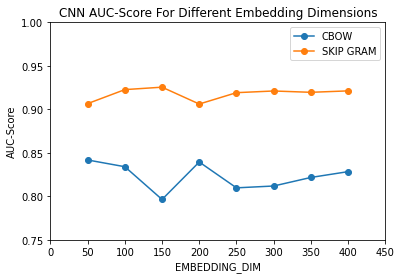

In [63]:
plt.plot(n,y1,label="CBOW",marker='o')
plt.plot(n,y2,label="SKIP GRAM",marker='o')
plt.axis([0,450,0.75,1.00])
plt.xlabel('EMBEDDING_DIM')
plt.ylabel('AUC-Score')
plt.legend()
plt.title('CNN AUC-Score For Different Embedding Dimensions')
plt.show()
